In [1]:
import netCDF4 as nc
import glob
import numpy as np
fs=glob.glob("output/subset_*.nc")
fs=sorted(fs)
y_lastbin=[]

x_data=[]
y_data=[]
p_type_data=[]
n_seq_data=[]
#print(fs)
y_nonz=[[]for k in range(44+18)]
x_nonz=[[]for k in range(44+18)]
xL=[]
yL=[]
diffL=[]
for f in fs:
    with nc.Dataset(f) as fh:
        bin_nodes=fh.variables['bin_nodes'][:]
        diffL.extend(bin_nodes[:,-1]-(bin_nodes[:,2]-2))

print(np.array(diffL).min(),np.array(diffL).max())


-22 22


In [48]:
import matplotlib.pyplot as plt
#h=plt.hist(diffL,bins=20)
print(len(fs))

645


In [18]:
n_files=len(fs)
x_data=[]
import tqdm
dn1L=[]
dn2L=[]
maskL=[]
prate_dist=np.zeros((48,40))
for f in tqdm.tqdm(fs[:n_files]):
    with nc.Dataset(f) as fh:        
        vars=fh.variables.keys()
        bin_nodes=fh.variables['bin_nodes'][:]
        sfc_bin=fh.variables['sfc_bin'][:]
        p_rate_cmb=fh.variables['p_rate_cmb'][:]
        dm=fh.variables['dm'][:]
        bin_zero_deg=fh.variables['bin_zero_deg'][:]
        bin_storm_top=fh.variables['bin_storm_top'][:]
        surface_type=fh.variables['surface_type'][:]
        pia=fh.variables['pia'][:]
        p_type=fh.variables['p_type'][:]
        dn1L.extend(bin_nodes[:,2]-bin_nodes[:,0])
        dn2L.extend(bin_nodes[:,4]-bin_nodes[:,2])
        for i,p_rate_cmb_1d in enumerate(p_rate_cmb):
            mask1d=np.zeros(48,dtype=np.float32)
            p_rate_cmb_rel=np.zeros(48,dtype=np.float32)
            for k in range(bin_nodes[i,0],bin_nodes[i,4]):
                ik=32+k-bin_nodes[i,2]
                if ik>=0 and ik<48:
                    mask1d[ik]=1
                    p_rate_cmb_rel[ik]=p_rate_cmb_1d[k]
                    ik_log=int(np.log10(1+p_rate_cmb_1d[k]/0.1)*10)
                    if ik_log>=0 and ik_log<40:
                        prate_dist[ik,ik_log]+=1
            maskL.append(mask1d)
            x_data.append(p_rate_cmb_rel)
                
        
        #break

100%|██████████| 645/645 [04:21<00:00,  2.46it/s]


3773281


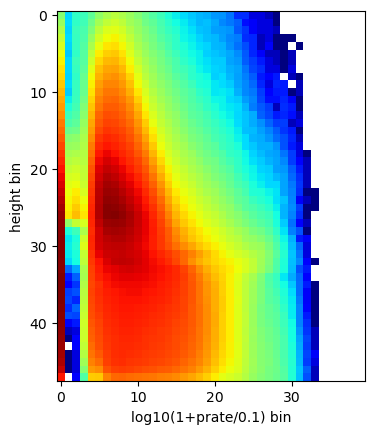

In [77]:
import matplotlib
plt.imshow(prate_dist,norm=matplotlib.colors.LogNorm(),cmap='jet')
plt.xlabel('log10(1+prate/0.1) bin')
plt.ylabel('height bin')

print(len(x_data))

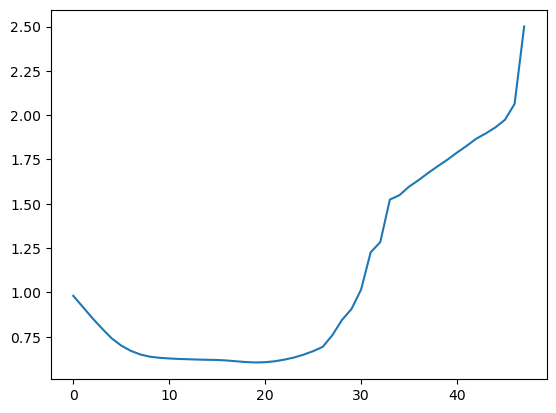

In [ ]:
x_data=np.array(x_data)
maskL=np.array(maskL)
a=np.nonzero(maskL)
p_rate_mean=np.zeros((48),dtype=np.float32)
for i in range(48):
    a=np.nonzero(maskL[:,i])
    if len(a[0])>30:
        p_rate_mean[i]=np.mean(x_data[a,i])

plt.plot(p_rate_mean)


In [45]:
import importlib
importlib.reload(autoEnc1d)
n_in=2
nf=8
latent1D_dim=8
nz=48
latent_dim=4
n_out=1
encoder=autoEnc1d.Encoder1D(n_in,nf,latent1D_dim,nz,latent_dim)
decoder= autoEnc1d.Decoder1D(latent_dim,latent1D_dim,nf,nz,n_out)
import torch
x=torch.randn(1,2,48)
z=encoder(x)
y=decoder(z)
print(z.shape)
print(y.shape)
print(encoder.__doc__)
class AutoEncoder1D(torch.nn.Module):
    def __init__(self,n_in,nf,latent1D_dim,nz,latent_dim,n_out):
        super(AutoEncoder1D,self).__init__()
        self.encoder=autoEnc1d.Encoder1D(n_in,nf,latent1D_dim,nz,latent_dim)
        self.decoder=autoEnc1d.Decoder1D(latent_dim,latent1D_dim,nf,nz,n_out)
    def forward(self,x):
        z=self.encoder(x)
        y=self.decoder(z)
        return y

autoencoder=AutoEncoder1D(n_in,nf,latent1D_dim,nz,latent_dim,n_out)

torch.Size([1, 4])
torch.Size([1, 1, 48])

class Encoder1D(nn.Module):
    def __init__(self, in_channels, nf,latent_dim1D, nz, latent_dim):
        super(Encoder1D, self).__init__()
        self.nf=nf
        self.conv1 = nn.Conv1d(in_channels, nf, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(nf, nf*2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(nf*2, nf*2, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv1d(nf*2, latent_dim1D, kernel_size=3, padding=1)
        self.fc = nn.Linear(latent_dim1D*nz//8, latent_dim)

    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(self.pool(x1)))
        x3 = F.relu(self.conv3(self.pool(x2)))
        x4 = F.relu(self.conv4(self.pool(x3)))
        z = x4.view(x4.size(0), -1)
        z = self.fc(z)
        return z



In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
"""
class Encoder1D(nn.Module):
    def __init__(self, in_channels, nf,latent_dim1D, nz, latent_dim):
        super(Encoder, self).__init__()
        self.nf=nf
        self.conv1 = nn.Conv1d(in_channels, nf, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(nf, nf*2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(nf*2, nf*2, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv1d(nf*2, latent_dim1D, kernel_size=3, padding=1)
        self.fc = nn.Linear(latent_dim1D*nz//8, latent_dim)

    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(self.pool(x1)))
        x3 = F.relu(self.conv3(self.pool(x2)))
        x4 = F.relu(self.conv4(self.pool(x3)))
        z = x4.view(x4.size(0), -1)
        z = self.fc(z)
        return z

class Decoder1D(nn.Module):
    def __init__(self, latent_dim, nf, latent_dim1D, nz, out_channels):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, latent_dim1D*nz//8)
        self.deconv1 = nn.ConvTranspose1d(latent_dim1D, nf*2, kernel_size=3, padding=1)
        self.deconv2 = nn.ConvTranspose1d(nf*2, nf*2, kernel_size=3, padding=1)
        self.deconv3 = nn.ConvTranspose1d(nf*2, nf, kernel_size=3, padding=1)
        self.deconv4 = nn.ConvTranspose1d(nf, out_channels, kernel_size=3, padding=1)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, z):
        x = self.fc(z)
        x = x.view(x.size(0), -1, 6)
        x = F.relu(self.deconv1(self.upsample(x)))
        x = F.relu(self.deconv2(self.upsample(x)))
        x = F.relu(self.deconv3(self.upsample(x)))
        x_hat = self.deconv4(x)
        return x_hat
"""

class Encoder1D(nn.Module):
    def __init__(self, in_channels, nf,latent_dim1D, nz, latent_dim):
        super(Encoder1D, self).__init__()
        self.nf=nf
        self.conv1 = nn.Conv1d(in_channels, nf, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(nf, nf*2, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv1d(nf*2, latent_dim1D, kernel_size=3, padding=1)
        self.fc = nn.Linear(latent_dim1D*nz//4, latent_dim)

    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(self.pool(x1)))
        x3 = F.relu(self.conv3(self.pool(x2)))
        z = x3.view(x3.size(0), -1)
        z = self.fc(z)
        return z

class Decoder1D(nn.Module):
    def __init__(self, latent_dim, nf, latent_dim1D, nz, out_channels):
        super(Decoder1D, self).__init__()
        self.fc = nn.Linear(latent_dim, latent_dim1D*nz//4)
        self.latent_dim1D=latent_dim1D
        self.deconv1 = nn.ConvTranspose1d(latent_dim1D, nf*2, kernel_size=3, padding=1)
        self.deconv3 = nn.ConvTranspose1d(nf*2, nf, kernel_size=3, padding=1)
        self.deconv4 = nn.ConvTranspose1d(nf, out_channels, kernel_size=3, padding=1)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, z):
        x = self.fc(z)
        x = x.view(x.size(0), -1, nz//4)    
        x = F.relu(self.deconv1(self.upsample(x)))
        x = F.relu(self.deconv3(self.upsample(x)))
        x_hat = self.deconv4(x)
        return x_hat


In [69]:
enc_model=Encoder1D(1,8,8,48,4)
x=torch.randn(1,1,48)
z=model(x)
dec_model=Decoder1D(4,8,8,48,1)
y=dec_model(z)
print(y.shape)
class AutoEncoder1D(torch.nn.Module):
    def __init__(self,n_in,nf,latent1D_dim,nz,latent_dim,n_out):
        super(AutoEncoder1D,self).__init__()
        self.encoder=autoEnc1d.Encoder1D(n_in,nf,latent1D_dim,nz,latent_dim)
        self.decoder=autoEnc1d.Decoder1D(latent_dim,latent1D_dim,nf,nz,n_out)
    def forward(self,x):
        z=self.encoder(x)
        y=self.decoder(z)
        return y

autoencoder=AutoEncoder1D(n_in,nf,latent1D_dim,nz,latent_dim,n_out)

torch.Size([1, 1, 48])


In [83]:
print(x_data.mean(axis=0))
print(x_data.std(axis=0))
#plt.plot(x_data.mean(axis=0),range(48))
#plt.plot(x_data.std(axis=0),range(48))
print(x_data.max())


[0.00256266 0.00306915 0.00372836 0.00458312 0.00566893 0.00702335
 0.00872147 0.01081561 0.01328367 0.01630617 0.01982463 0.0239987
 0.02897555 0.03496894 0.04219168 0.05100698 0.06187593 0.07528634
 0.09239437 0.11413548 0.14176379 0.17546426 0.21471423 0.25852206
 0.3058339  0.3551147  0.40352318 0.41211292 0.42935988 0.4332034
 0.4655602  0.57006305 0.60374504 0.6854369  0.6598036  0.6468254
 0.63070565 0.6152994  0.5989247  0.58197063 0.56565046 0.54838127
 0.5333749  0.5149666  0.49329817 0.4543353  0.3808663  0.26019457]
[0.13257512 0.1427043  0.15391463 0.17258838 0.18819256 0.20401119
 0.22100556 0.24453245 0.26516652 0.3001462  0.32364067 0.350394
 0.3805723  0.41045702 0.44484827 0.48467594 0.53592926 0.5834314
 0.6506294  0.70898587 0.7785287  0.8445385  0.91669095 1.0013949
 1.0728307  1.1852227  1.2617579  1.3650539  1.5608068  1.746811
 1.9690899  2.21953    2.2842782  2.342187   2.1508822  2.1961353
 2.2410593  2.2770398  2.3006508  2.3307312  2.3643553  2.3949158
 2.42

(3773281, 48)
(48,)
(48,)
3.3774297


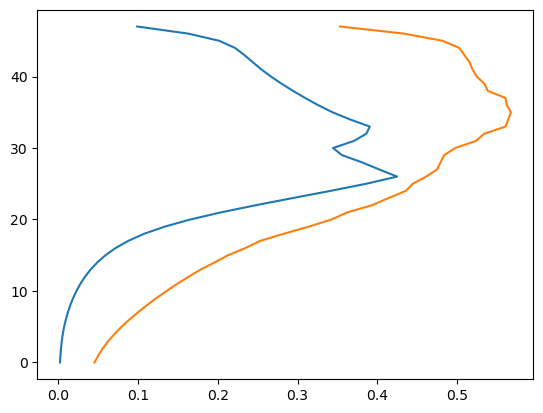

In [88]:

x_data_log=np.log10(1+x_data/0.1)
print(x_data_log.shape)
x_data_log_mean=x_data_log.mean(axis=0)
x_data_log_std=x_data_log.std(axis=0)
print(x_data_log_mean.shape)
print(x_data_log_std.shape)
plt.plot(x_data_log.mean(axis=0),range(48))
plt.plot(x_data_log.std(axis=0),range(48))
print(x_data_log.max())
x_data_scaled=(x_data_log-x_data_log_mean)/x_data_log_std

In [89]:

x_data=np.array(x_data)
maskL=np.array(maskL)
print(x_data.shape[0]/50)
#print(maskL.shape)
x_torch=torch.tensor(np.concatenate((x_data_scaled[::10,np.newaxis,:],maskL[::10,np.newaxis,:]),axis=1),dtype=torch.float32)
mask_torch=torch.tensor(maskL[::10,np.newaxis,:],dtype=torch.float32)
nt=x_torch.shape[0]
print(nt)
n_train=nt*4//5
dataset=torch.utils.data.TensorDataset(x_torch[:n_train],mask_torch[:n_train])
train_loader=torch.utils.data.DataLoader(dataset,batch_size=100,shuffle=True)
print(n_train)
import torch.optim as optim
criterion=torch.nn.MSELoss()
n_epochs=30
latent_dim=6
autoencoder=AutoEncoder1D(n_in,nf,latent1D_dim,nz,latent_dim,n_out)


75465.62
377329
301863


In [90]:
n_epochs=10
optimizer=optim.Adam(autoencoder.parameters(),lr=0.001)
for epoch in range(n_epochs):
    running_loss=0.0
    for data,mask_ in train_loader:
        inputs=data
        optimizer.zero_grad()
        outputs=autoencoder(inputs)
        loss=criterion(outputs*mask_,inputs[:,0:1,:]*mask_)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
    print('[%d] loss: %.3f'%(epoch,running_loss/len(train_loader)))

scripted_model=torch.jit.script(autoencoder)
scripted_model.save('autoencoder1d.pt')


[0] loss: 0.057
[1] loss: 0.028
[2] loss: 0.025
[3] loss: 0.023
[4] loss: 0.021
[5] loss: 0.020
[6] loss: 0.020
[7] loss: 0.019
[8] loss: 0.019
[9] loss: 0.019


In [ ]:
import pickle
scaler={'mean':x_data_log_mean,'std':x_data_log_std}
with open('auto_enc_scaler.pkl','wb') as f:
    pickle.dump(scaler,f)
# load scripted model


In [92]:
print(autoencoder.decoder)

Decoder1D(
  (fc): Linear(in_features=6, out_features=48, bias=True)
  (deconv1): ConvTranspose1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (deconv2): ConvTranspose1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (deconv3): ConvTranspose1d(16, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (deconv4): ConvTranspose1d(8, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  (upsample): Upsample(scale_factor=2.0, mode='nearest')
)


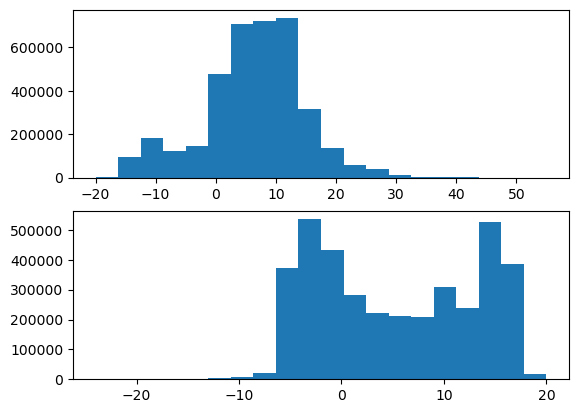

In [8]:
import matplotlib.pyplot as plt
plt.subplot(2,1,1)
h1=plt.hist(dn1L,bins=20)
plt.subplot(2,1,2)
h2=plt.hist(dn2L,bins=20)